# Sports 1M C3D Network to Keras

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.optimizers import SGD

Using Theano backend.


In [4]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    # 1st layer group
    model.add(Convolution3D(64, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv1',
                            subsample=(1, 1, 1), 
                            input_shape=(3, 16, 112, 112)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), 
                           border_mode='valid', name='pool1'))
    # 2nd layer group
    model.add(Convolution3D(128, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv2',
                            subsample=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool2'))
    # 3rd layer group
    model.add(Convolution3D(256, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv3a',
                            subsample=(1, 1, 1)))
    model.add(Convolution3D(256, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv3b',
                            subsample=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool3'))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))
    # 4th layer group
    model.add(Convolution3D(512, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv4a',
                            subsample=(1, 1, 1)))
    model.add(Convolution3D(512, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv4b',
                            subsample=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool4'))
    # 5th layer group
    model.add(Convolution3D(512, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv5a',
                            subsample=(1, 1, 1)))
    model.add(Convolution3D(512, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv5b',
                            subsample=(1, 1, 1)))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(2048, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(2048, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))
    if summary:
        print(model.summary())
    return model

model = get_model(summary=True)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
conv1 (Convolution3D)              (None, 64, 16, 112, 5248        convolution3d_input_1[0][0]      
____________________________________________________________________________________________________
pool1 (MaxPooling3D)               (None, 64, 16, 56, 50           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution3D)              (None, 128, 16, 56, 221312      pool1[0][0]                      
____________________________________________________________________________________________________
pool2 (MaxPooling3D)               (None, 128, 8, 28, 20           conv2[0][0]                      
___________________________________________________________________________________________

# Loding Paramater

In [7]:
from kerasmodelzoo.models import c3d

model = c3d.model(weights=True, summary=True)

('Downloading data from', 'https://www.dropbox.com/s/ypiwalgtlrtnw8b/c3d-sports1M_weights.h5?dl=1')


100% (319994444 of 319994444) |############| Elapsed Time: 0:03:08 Time: 0:03:08


____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
conv1 (Convolution3D)              (None, 64, 16, 112, 5248        convolution3d_input_3[0][0]      
____________________________________________________________________________________________________
pool1 (MaxPooling3D)               (None, 64, 16, 56, 50           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution3D)              (None, 128, 16, 56, 221312      pool1[0][0]                      
____________________________________________________________________________________________________
pool2 (MaxPooling3D)               (None, 128, 8, 28, 20           conv2[0][0]                      
___________________________________________________________________________________________

Get the model weights

In [9]:
import h5py

model.save_weights("sports1M_weights.h5", overwrite=True)
json_string = model.to_json()
with open("sports1M_model.json", "w") as f:
    f.write(json_string)

# Test

In [10]:
from keras.models import model_from_json

model = model_from_json(open("sports1M_model.json", "r").read())
model.load_weights("sports1M_weights.h5")
model.compile(loss="mean_squared_error", optimizer="sgd")

For testing, we are going to load the weight

In [13]:
with open("../model/labels.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
print("Total labels: {}".format(len(labels)))

Total labels: 487


For testing we are going to load video from the Suports1M data sets and pass it through the model.

In [15]:
import cv2
import numpy as np

cap = cv2.VideoCapture("../model/test_data.mp4")

vid = []
while True:
    ret, img = cap.read()
    if not ret:
        break
    vid.append(cv2.resize(img, (171, 128)))
vid = np.array(vid, dtype=np.float32)

Plot a frame of the video

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


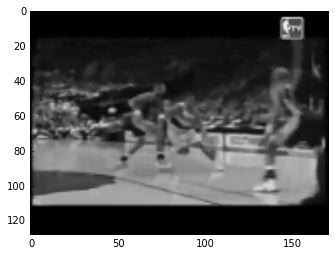

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(vid[2000]/256)

Now form the video extra 16 fram clip and crop the center to get 3*16*112*112

In [20]:
X = vid[2000:2016, 8:120, 30:142, :].transpose((3, 0, 1, 2))
output = model.predict_on_batch(np.array([X]))

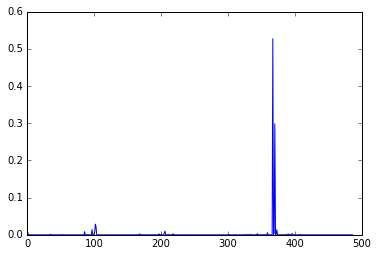

In [32]:
plt.plot(output[0])

In [31]:
print('Position of maximum probability: {}'.format(output[0].argmax()))
print('Maximum probability: {}'.format(max(output[0])))
print('Corresponding label: {}'.format(labels[output[0].argmax()]))

# sort top five predictions from softmax output
top_inds = output[0].argsort()[::-1][:5]  # reverse sort and take five largest items
print('\nTop 5 probabilities and labels:')
for i in top_inds:
    print('{:.5f} {}'.format(output[0][i], labels[i]))

Position of maximum probability: 367
Maximum probability: 0.527280986309
Corresponding label: basketball

Top 5 probabilities and labels:
0.52728 basketball
0.29820 streetball
0.02856 greco-roman wrestling
0.02103 freestyle wrestling
0.01411 wrestling
